# Capturing watersheds


In [1]:
# Importando librerías

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from pyproj.crs import crs
import geopandas as gpd
from pysheds.grid import Grid
%matplotlib inline

### Imprimir archivos

In [2]:
url = 'src/LocalDem.tif'
grid = Grid.from_raster(url, data_name='dem')

In [3]:
def plotFigure(data, label, cmap='Blues'):
    plt.figure(figsize=(12,10))
    plt.imshow(data, extent=grid.extent, cmap=cmap)
    plt.colorbar(label=label)
    plt.grid()

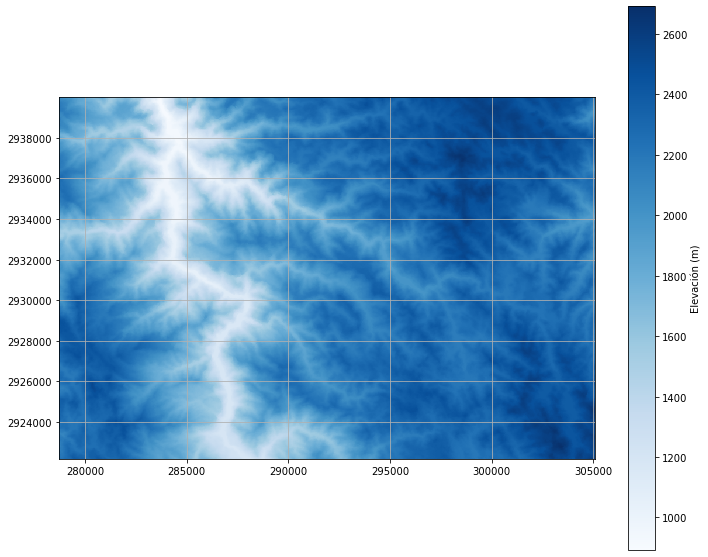

In [4]:
plotFigure(grid.dem, 'Elevación (m)')

In [5]:
#N    NE    E    SE    S    SW    W    NW
dirmap = (64,  128,  1,   2,    4,   8,    16,  32)
grid.flowdir(data='dem', out_name='dir', dirmap=dirmap)

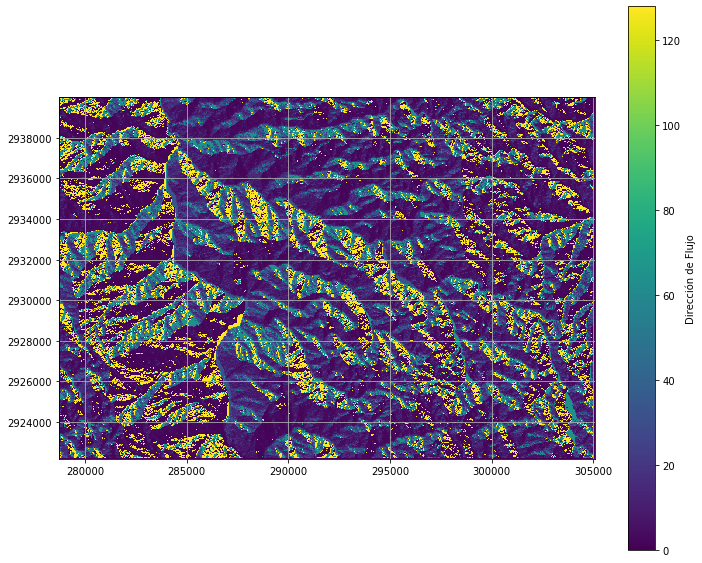

In [6]:
plotFigure(grid.dir,'Dirección de Flujo','viridis')

In [7]:
# Specify pour point
x, y = 285612.017,2936416.682

In [8]:
# Delimitar la cuenca hidrográfica
grid.catchment(data='dir', x=x, y=y, dirmap=dirmap, out_name='catch',
               recursionlimit=15000, xytype='label', nodata_out=0)
# Clip the bounding box to the catchment
grid.clip_to('catch')
# Get a view of the catchment
demView = grid.view('dem', nodata=np.nan)

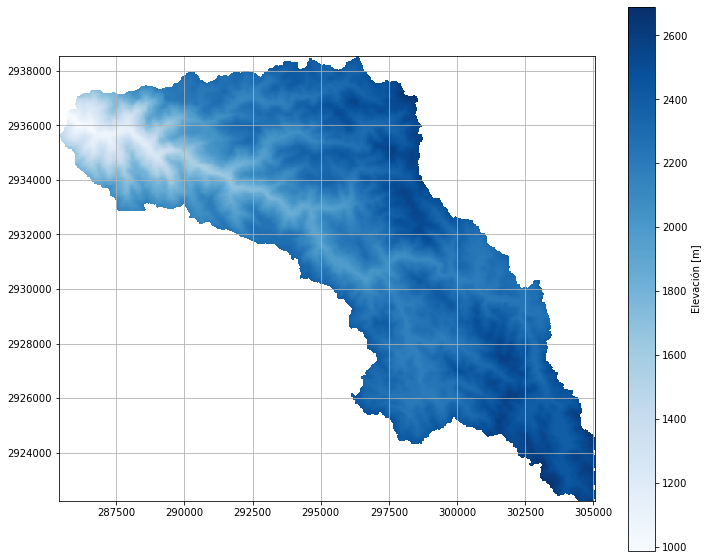

In [9]:
plotFigure(demView,'Elevación [m]')

In [12]:
out_url = 'src/clippedElevations.tif'

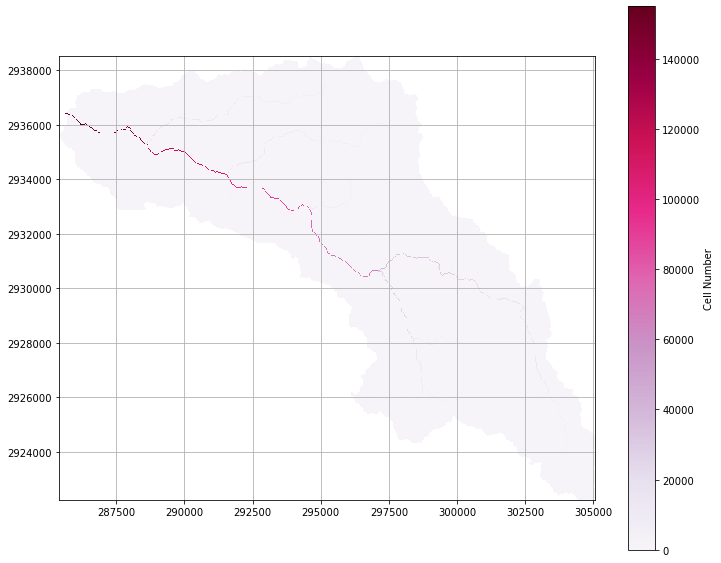

In [13]:
#export selected raster
grid.to_raster(demView, out_url)
grid.accumulation(data='catch', dirmap=dirmap, pad_inplace=False, out_name='acc')
accView = grid.view('acc', nodata=np.nan)
plotFigure(accView,"Cell Number",'PuRd')

In [59]:
streams = grid.extract_river_network('catch', 'acc', threshold=200, dirmap=dirmap)

In [57]:
def saveDict(dic,file):
    f = open(file,'w')
    f.write(str(dic))
    f.close()

In [15]:
out_json= 'src/streams.geojson'

In [16]:
#save geojson as separate file
saveDict(streams, out_json)

streamNet = gpd.read_file(out_json)
streamNet.crs = crs.CRS.from_user_input(32613)

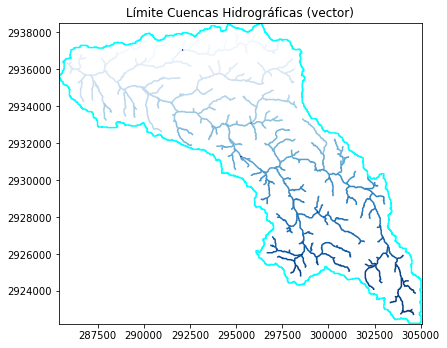

In [63]:
# The polygonize argument defaults to the grid mask when no arguments are supplied
shapes = grid.polygonize()
coords = None
# Plot catchment boundaries
fig, ax = plt.subplots(figsize=(6.5, 6.5))

for shape in shapes:
    coords = np.asarray(shape[0]['coordinates'][0])
    ax.plot(coords[:,0], coords[:,1], color='cyan')

ax.set_xlim(grid.bbox[0], grid.bbox[2])
ax.set_ylim(grid.bbox[1], grid.bbox[3])
ax.set_title('Límite Cuencas Hidrográficas (vector)')
gpd.plotting.plot_dataframe(streamNet, None, cmap='Blues', ax=ax)
plt.show()

In [ ]:
saveDict(shapes, out_json)

In [19]:
import folium as fl

In [37]:
out_json = 'src/salida.geojson'

In [50]:
m = fl.Map(location=[26.5, -107.04], width=750, height=500, zoom_start=12)
fl.GeoJson(out_json, name='Cuenca').add_to(m)
fl.GeoJson(out_json, name='Cuenca').add_to(m)
fl.LayerControl().add_to(m)
m

In [ ]:

mplleaflet.display(fig=ax.figure, crs=streamNet.crs, tiles='esri_aerial')

# The polygonize argument defaults to the grid mask when no arguments are supplied
shapes = grid.polygonize()

# Plot catchment boundaries
fig, ax = plt.subplots(figsize=(6.5, 6.5))

for shape in shapes:
    coords = np.asarray(shape[0]['coordinates'][0])
    ax.plot(coords[:,0], coords[:,1], color='cyan')

ax.set_xlim(grid.bbox[0], grid.bbox[2])
ax.set_ylim(grid.bbox[1], grid.bbox[3])
ax.set_title('Catchment boundary (vector)')
gpd.plotting.plot_dataframe(streamNet, None, cmap='Blues', ax=ax)

#ax = streamNet.plot()
mplleaflet.display(fig=ax.figure, crs=streamNet.crs, tiles='esri_aerial')